<a href="https://colab.research.google.com/github/treezy254/Data-Science-Prep/blob/master/hotel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [15]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )


features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]

features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid')
])

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

Epoch 1/200
175/175 [==============================] - 7s 27ms/step - loss: 0.4800 - binary_accuracy: 0.7714 - val_loss: 0.4311 - val_binary_accuracy: 0.8040
Epoch 2/200
175/175 [==============================] - 4s 21ms/step - loss: 0.4224 - binary_accuracy: 0.8009 - val_loss: 0.4009 - val_binary_accuracy: 0.8150
Epoch 3/200
175/175 [==============================] - 4s 21ms/step - loss: 0.4086 - binary_accuracy: 0.8086 - val_loss: 0.3940 - val_binary_accuracy: 0.8168
Epoch 4/200
175/175 [==============================] - 4s 25ms/step - loss: 0.4015 - binary_accuracy: 0.8118 - val_loss: 0.3888 - val_binary_accuracy: 0.8208
Epoch 5/200
175/175 [==============================] - 4s 21ms/step - loss: 0.3965 - binary_accuracy: 0.8149 - val_loss: 0.3841 - val_binary_accuracy: 0.8218
Epoch 6/200
175/175 [==============================] - 4s 21ms/step - loss: 0.3913 - binary_accuracy: 0.8186 - val_loss: 0.3818 - val_binary_accuracy: 0.8234
Epoch 7/200
175/175 [==============================]

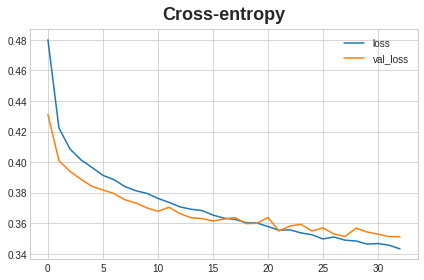

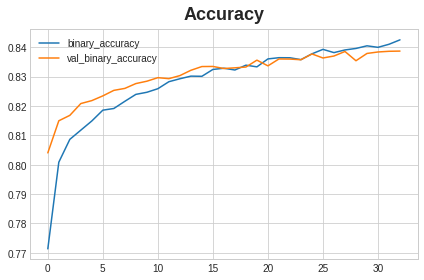

In [19]:
earlystopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights= True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[earlystopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Cross-entropy')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title='Accuracy')